<a href="https://colab.research.google.com/github/Reyhaneh2001/mini_mood_transformer/blob/main/MiniMoodTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# **Parameters**

In [24]:
VOCAB_SIZE = 10000
MAXLEN = 200
EMBED_DIM = 64
NUM_HEADS = 2
FF_DIM = 64

# **Load & explore dataset**

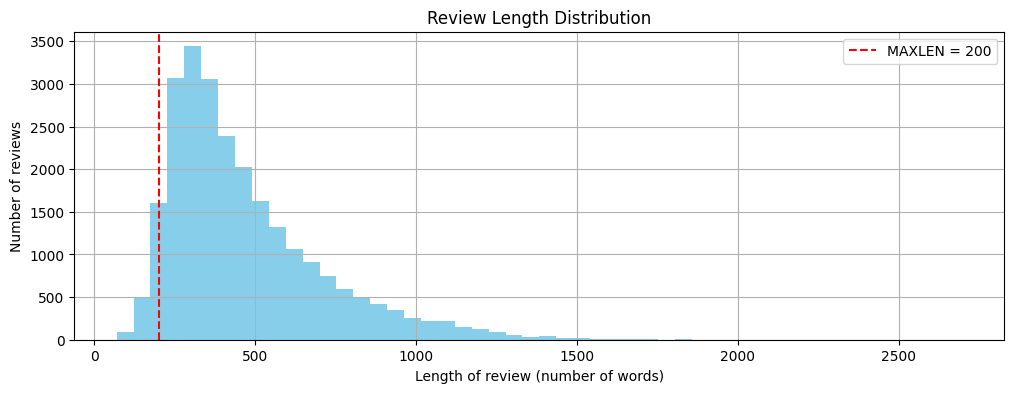

<ipython-input-25-b1d405ae7585>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='pastel')


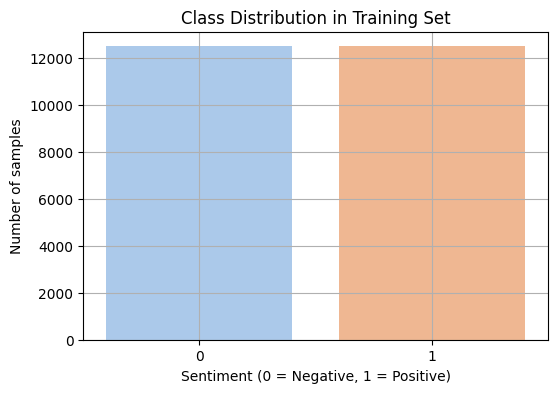

In [25]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)

all_lengths = [len(seq) for seq in x_train + x_test]

plt.figure(figsize=(12, 4))
plt.hist(all_lengths, bins=50, color='skyblue')
plt.axvline(MAXLEN, color='red', linestyle='--', label=f'MAXLEN = {MAXLEN}')
plt.title('Review Length Distribution')
plt.xlabel('Length of review (number of words)')
plt.ylabel('Number of reviews')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x=y_train, palette='pastel')
plt.title('Class Distribution in Training Set')
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('Number of samples')
plt.grid(True)
plt.show()

# **Preprocessing: Padding**

In [26]:
x_train = pad_sequences(x_train, maxlen=MAXLEN)
x_test = pad_sequences(x_test, maxlen=MAXLEN)

# **Define Transformer Block**

In [27]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output))

# **Build Transformer Model**

In [28]:
inputs = tf.keras.Input(shape=(MAXLEN,))
x = layers.Embedding(VOCAB_SIZE, EMBED_DIM)(inputs)
x = TransformerBlock(EMBED_DIM, NUM_HEADS, FF_DIM)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 200, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 200, 64)        │        41,792 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,905 (2.61 MB)

 Trainable params: 683,905 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

# **Train**

In [29]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=128,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 134s 822ms/step - accuracy: 0.5952 - loss: 0.6427 - val_accuracy: 0.8634 - val_loss: 0.3242
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 130s 827ms/step - accuracy: 0.8941 - loss: 0.2784 - val_accuracy: 0.8822 - val_loss: 0.2873
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 149s 873ms/step - accuracy: 0.9365 - loss: 0.1716 - val_accuracy: 0.8782 - val_loss: 0.3208
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 135s 828ms/step - accuracy: 0.9621 - loss: 0.1143 - val_accuracy: 0.8682 - val_loss: 0.3796


# **Evaluation**

In [31]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")
print("\nTest Accuracy:", model.evaluate(x_test, y_test)[1])
print("\nClassification Report:\n", classification_report(y_test, y_pred))

782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 59ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - accuracy: 0.8721 - loss: 0.3031

Test Accuracy: 0.8722000122070312

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87     12500
           1       0.86      0.89      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



# **Confusion matrix**

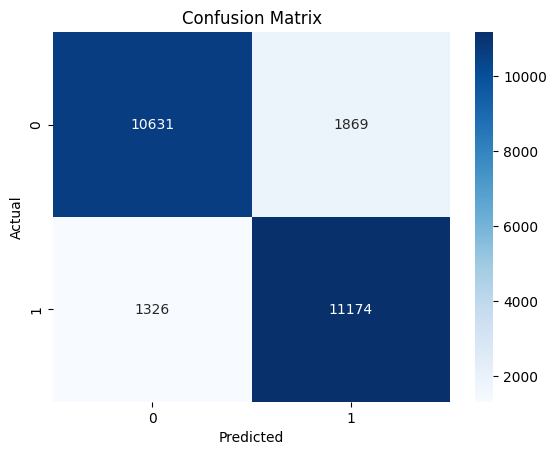

In [32]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Visualization: Sample Predictions**

In [41]:
word_index = imdb.get_word_index()
reverse_word_index = {value+3: key for key, value in word_index.items()}
reverse_word_index[0] = "<PAD>"
reverse_word_index[1] = "<START>"
reverse_word_index[2] = "<UNK>"
reverse_word_index[3] = "<UNUSED>"

SPECIAL_TOKENS = {"<PAD>", "<START>", "<UNK>", "<UNUSED>"}

def decode_review(text_ids):
    return ' '.join([reverse_word_index.get(i, '?') for i in text_ids if reverse_word_index.get(i, '?') not in SPECIAL_TOKENS])

sample_indices = np.random.choice(len(x_test), 15, replace=False)

for idx in sample_indices:
    review = decode_review(x_test[idx])
    prediction = int(y_pred[idx])
    label = y_test[idx]
    sentiment = "Positive" if prediction == 1 else "Negative"
    true_sentiment = "Positive" if label == 1 else "Negative"

    print(f"Review (first 300 chars):\n{review[:300]}...")
    print(f"✅ True Sentiment: {true_sentiment}")
    print(f"🎯 Predicted: {sentiment}")
    print("__"*60)

Review (first 300 chars):
knew like he did here they are stunt flying crashing exploding in the air and everything you can think of plus a fascinating glimpse of commercial air in 1932 as well and there is a good strong story excellently played by the richard the silent star who made several films with d w griffith sally and...
✅ True Sentiment: Positive
🎯 Predicted: Positive
________________________________________________________________________________________________________________________
Review (first 300 chars):
i saw this originally on channel 4 uk and it was a fantastic film that left a great impression on me however i saw it on irish tv recently and there was an added narration by roy we're going to need a bigger boat this ruined the film for me his monologue adds absolutely nothing to the film and if an...
✅ True Sentiment: Positive
🎯 Predicted: Negative
________________________________________________________________________________________________________________________


<ipython-input-41-8b18f8966c66>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = int(y_pred[idx])
